# Setup

In [1]:
%run setup.py

In [2]:
import haversine as hs
import osmnx as ox
from shapely.geometry import LineString, Point
from sklearn.neighbors import KDTree

In [3]:
aus = City('Austin, TX', IO.data)
cam = City('Cambridge, MA', IO.data)
sea = City('Seattle, WA', IO.data)
tor = City('City of Toronto', IO.data, 'Toronto')

---
# Prepare geometry

## Buildings (OSM)

In [4]:
def save_osm_buildings(city, timeout=480):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        b4_timeout = ox.settings.timeout
        ox.settings.timeout = timeout
        bld = ox.geometries_from_place(city.geocode, tags={'building': True})
        bld['geometry'] = bld.geometry.to_crs(CRS_M).centroid.to_crs(CRS_DEG)
        ox.settings.timeout = b4_timeout
    city.save('osm_buildings', (bld.reset_index().rename(columns={'building':'kind'})
                                [['osmid', 'element_type', 'kind', 'geometry']]
                                .rename_axis('id').to_crs(CRS_DEG)))

**AUSTIN**

**CAMBRIDGE**

**SEATTLE**

**TORONTO**

## OSM POIs

In [5]:
def save_osm_pois(city, tags=['amenity','healthcare','leisure','office','shop']):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        poi = ox.geometries_from_place(city.geocode, tags={x: True for x in tags})
    geom = poi.to_crs(CRS_M).centroid.to_crs(CRS_DEG).rename('geometry').reset_index()
    poi = geom.merge(pd.concat([poi[x].dropna().rename('subcategory').reset_index().assign(category=x)
                                for x in tags]), on=('element_type','osmid')).rename_axis('id')
    city.save('osm_pois', poi)

**AUSTIN**

**CAMBRIDGE**

**SEATTLE**

**TORONTO**

## SafeGraph POIs

**AUSTIN**

**CAMBRIDGE**

**SEATTLE**

**TORONTO**

## Land use

[**AUSTIN**](https://data.austintexas.gov/Locations-and-Maps/Land-Use-Inventory-Detailed/fj9m-h5qy)

In [6]:
aus.lu_categories = Pdf(columns=['lu_code', 'category', 'dmd_kind'], data=[(100, 'Single Family', 'O'), (113, 'Mobile Homes', 'O'), (150, 'Duplex', 'O'), (160, 'Large-lot Single Family', 'O'), (210, 'Three/Fourplex', 'O'), (220, 'Apartment/Condo', 'O'), (230, 'Group Quarters', 'O'), (240, 'Retirement Housing', 'O'), (300, 'Commercial', 'D'), (330, 'Mixed Use', 'D'), (400, 'Office', 'D'), (510, 'Manufacturing', 'D'), (520, 'Warehousing', 'D'), (530, 'Miscellanrous Industrial', 'D'), (560, 'Resource Extraction (Mining)', 'D'), (570, 'Landfills', 'D'), (610, 'Semi-institutional Housing', 'O'), (620, 'Hospital', 'D'), (630, 'Government Services', 'D'), (640, 'Educational', 'D'), (650, 'Meeting and Assembly', 'D'), (670, 'Cemetery', 'D'), (680, 'Cultural Services', 'D'), (710, 'Parks/Greenbelts', 'D'), (720, 'Golf Courses', 'D'), (740, 'Common Areas', 'D'), (750, 'Preserves', 'D'), (810, 'Railroad Facilities', 'D'), (820, 'Transportation Facilities', 'D'), (830, 'Aviation Facilities', 'D'), (840, 'Marinas', 'D')]).disp()

31 rows x 3 cols; Memory: 0.0 MiB


,lu_code,category,dmd_kind
,<int64>,<object>,<object>
0,100,Single Family,O


[**CAMBRIDGE**](https://www.cambridgema.gov/GIS/gisdatadictionary/CDD/CDD_LandUse)

In [7]:
cam.lu_categories = Pdf(columns=['category', 'dmd_kind'], data=[('Residential', 'O'), ('Mixed Use Residential', 'O'), ('Commercial', 'D'), ('Office', 'D'), ('Transportation', 'D'), ('Higher Education', 'D'), ('Charitable/Religious', 'D'), ('Office/R&D', 'D'), ('Education', 'D'), ('Industrial', 'D'), ('Assisted Living/Boarding House', 'O'), ('Mixed Use Commercial', 'D'), ('Education Residential', 'O'), ('Government Operations', 'D'), ('Utility', 'D'), ('Health', 'D'), ('Mixed Use Education', 'D')])

[**SEATTLE**](https://catalog.data.gov/dataset/zoned-development-capacity-by-development-site-2020-v-1-3-151fe)

In [8]:
sea.lu_categories = Pdf(columns=['category', 'dmd_kind'], data=[('Single Family', 'O'), ('Multi-Family', 'O'), ('Commercial/Mixed-Use', 'D'), ('Industrial', 'D'), ('Parks/Open Space/Cemeteries', 'D'), ('Major Institution And Public Facilities/Utilities', 'D')])

[**TORONTO**](https://borealisdata.ca/dataset.xhtml?persistentId=doi:10.5683/SP3/1VMJAG)

Downloaded the huge parcel land-use database from https://borealisdata.ca/dataset.xhtml?persistentId=doi:10.5683/SP3/1VMJAG, extracted the zipped file and copied the shapefile `./TorontoLanduse/Landuse/data/Vector/Derived/LandUseByParcel2019_2021v0120211221.shp` to UMNI5.

In [9]:
tor.lu_categories = Pdf(columns=['category', 'dmd_kind'], data=[('Neighbourhoods', 'O'), ('MixedUse', 'D'), ('ApartmentNeighbourhoods', 'O'), ('CoreEmploymentAreas', 'D'), ('Parks', 'O'), ('GeneralEmployment', 'D'), ('UtilityCorridors', 'D'), ('Institutional', 'D')])

## Population

In [10]:
%time us_counties = gpd.read_file(IO.data + 'raw/USA_counties.zip').rename(columns=str.lower).disp(0) # time: 3s

3,234 rows x 18 cols; Memory: 2.7 MiB; CRS: epsg:4269


,statefp,countyfp,countyns,geoid,name,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<int64>,<int64>,<object>,<object>,<geometry>


CPU times: user 2.11 s, sys: 190 ms, total: 2.3 s
Wall time: 2.31 s


In [11]:
def get_acs(city, counties, bg_root=IO.data + 'USA/cbgs/',
            fields=mk.acs.IMP_FIELDS, save=True):
    city_limit = city.load('boundary')[['geometry']].to_crs(counties.crs)
    gdf = gpd.sjoin(city_limit, counties)
    statefp = str(gdf['statefp'].iloc[0])
    countyfps = ','.join(gdf['countyfp'].astype(str))
    geo = [('state', statefp), ('county', countyfps), ('block group', '*')]
    col_codes, col_names = list(zip(*fields.items()))
    acs = mk.acs.download(geo, col_codes).rename(columns=fields).reset_index()
    s, c, t, b = [acs.pop(x) for x in ['state','county','tract','block group']]
    acs.index = pd.Index(s + c + t + b, name='geoid')
    bgs = gpd.read_file(bg_root + f'{int(statefp)}.zip')
    bgs = (gpd.sjoin(bgs.to_crs(CRS_DEG), city_limit.to_crs(CRS_DEG))
           .rename(columns=str.lower).astype({'geoid': str})[['geoid', 'geometry']])
    acs = bgs.merge(acs.reset_index(), on='geoid').set_index('geoid')
    if save:
        city.save('acs', acs)
    return acs

**AUSTIN**

**CAMBRIDGE**

**SEATTLE**

**TORONTO**

Could not find population by 158 neighborhood but found population estimate for 2021 in the neighborhood crime data layer obtained from https://open.toronto.ca/dataset/neighbourhood-crime-rates/

### Visualize

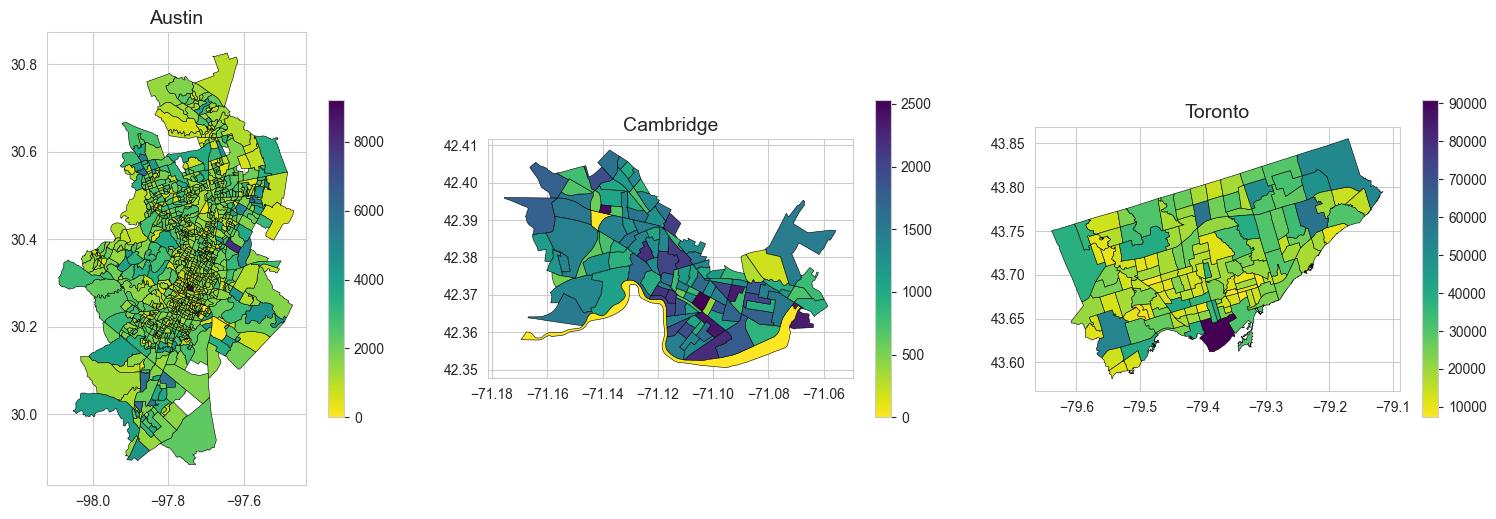

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6), dpi=100)
for ax, city in zip(ax, [aus, cam, tor]):
    city.load('acs').astype({'popu': int})\
    .plot(ax=ax, column='popu', legend=True, cmap='viridis_r',
          legend_kwds=dict(shrink=0.7), linewidth=0.4, edgecolor='k')
    # ax.grid(False)
    ax.set_title(city.name)

## OD points
- Classify builgins as origin or destination type (or both)
- Assign buildings population assuming uniform population distribution among all origin (residential) buildings within each block group
- Combine OSM and SafeGraph POIs as destinations to the mix to create the set of OD points

In [13]:
def get_od_points(city, max_people_per_bld=500, save=True):
    # load buildings and SafeGraph and OSM POIs
    sg_pois = city.load('sg_pois').rename(columns={'placekey':'base_id', 'top_category':'category'})
    osm_pois = city.load('osm_pois').rename(columns={'osmid':'base_id'})
    bld = city.load('osm_buildings').rename(columns={'osmid':'base_id'})
    # assign land use to buildings
    lu = city.load('land_use')
    bld = gpd.sjoin(bld, lu, predicate='within').drop(columns='index_right')
    bld['origin'] = bld['dmd_kind'] == 'O'
    # add enclosing CBG's population info to buildings
    popu = (city.load('acs')[['popu','geometry']].astype({'popu': float})
            .query('popu > 0').astype({'popu': int}).rename(columns={'popu':'popu_cbg'}))
    bld = gpd.sjoin(bld, popu.reset_index(), predicate='within').drop(columns='index_right')
    # divide the CBG population uniformly to all origin buildings
    popu_per_bld = (bld.query('origin').groupby('geoid')['popu_cbg'].agg(['count','first'])
                    .assign(weight = lambda df: df['first']/df['count'])
                    ['weight'].clip(0, max_people_per_bld))
    bld = bld.merge(popu_per_bld, on='geoid')
    # combine buildings and POIs to form OD points
    odpt = pd.concat([
        bld[['origin','base_id','category','weight','geometry']].assign(source='building'),
        sg_pois[['base_id','category','geometry']].assign(source='safegraph', origin=False),
        osm_pois[['base_id','category','geometry']].assign(source='osm', origin=False)
    ]).reset_index(drop=True).rename_axis('id')
    odpt['category'] = odpt['category'].str.upper()
    odpt.loc[~odpt['origin'], 'weight'] = 0
    odpt['lon'], odpt['lat'] = zip(*[x.coords[0] for x in odpt.geometry])
    if save:
        city.save('od_points', odpt)
    return odpt

**AUSTIN**

**CAMBRIDGE**

**SEATTLE**

**TORONTO**

## Closest pednet nodes to OD points
Closest node is not the one obtained from direct nearest point detection between nodes & buildings. Rather, it is the node which is closer of the two end points of the building's closest edge. Also, the distance between this node (edge endpoint) and the closest point on the walkway along the walkway is also computed.

In [14]:
def get_odpt2node(city, spacing=5, save=True):
    nodes = city.load('full_pednet_nodes').reset_index().to_crs(CRS_M)
    edges = city.load('full_pednet_edges').reset_index().to_crs(CRS_M)
    odpt = city.load('od_points').rename_axis('odpt_id').reset_index().to_crs(CRS_M)
    (odpt_ids, eids), dists = edges.sindex.nearest(
        odpt.geometry, return_all=False, return_distance=True)
    odpt_ids = odpt.iloc[odpt_ids]['odpt_id'].values
    odpt2edge = Pdf({'odpt_id': odpt_ids, 'eid': eids, 'dist_odpt2cp': dists})
    odpt = odpt[['odpt_id', 'geometry']].merge(odpt2edge, on='odpt_id')
    E = (edges.merge(odpt.drop(columns='geometry'), on='eid').drop_duplicates('eid')
         [['eid','geometry','len','src_vid','trg_vid']])
    E['dist'] = E['len'].apply(lambda x: list(np.arange(0, x+1e-4, spacing)) + [x])
    pts = E.explode('dist').reset_index(drop=True)
    pts['geometry'] = [line.interpolate(dist) for line, dist in
                       tqdm(zip(pts.geometry, pts['dist']), total=pts.shape[0])]
    pts = Gdf(pts, crs=CRS_M).rename_axis('pt_id')
    odpt_idx, pts_idx = pts.sindex.nearest(odpt.geometry, return_all=False)
    filt_odpt = (odpt.iloc[odpt_idx].reset_index(drop=True).to_crs(CRS_DEG)
                 .rename(columns={'geometry':'odpt_geom'})
                 [['odpt_id','odpt_geom','dist_odpt2cp']])
    filt_pts = (pts.iloc[pts_idx].reset_index(drop=True).to_crs(CRS_DEG)
                .rename(columns={'dist':'dist_src2cp', 'geometry':'cp_geom'})
                .assign(dist_cp2trg = lambda df: df['len'] - df['dist_src2cp'])
                .query('dist_cp2trg >= 0'))
    odpt = pd.concat([filt_odpt, filt_pts], axis=1).dropna(subset=['odpt_geom','cp_geom'])
    odpt['geometry'] = gpd.GeoSeries([LineString(x) for x in tqdm(
        zip(odpt['odpt_geom'], odpt['cp_geom']), total=odpt.shape[0])], crs=CRS_DEG)
    src = odpt[odpt['dist_src2cp'] <= odpt['len']/2].assign(is_source=True)
    trg = odpt[odpt['dist_src2cp'] > odpt['len']/2].assign(is_source=False)
    src['vid'], src['dist_cp2node'] = src['src_vid'], src['dist_src2cp']
    trg['vid'], trg['dist_cp2node'] = trg['trg_vid'], trg['dist_cp2trg']
    odpt2node = Gdf(pd.concat([src, trg]).astype({'dist_odpt2cp': float, 'dist_cp2node': float})
                    ['odpt_id vid is_source dist_odpt2cp dist_cp2node geometry'.split()]
                    .dropna(subset='geometry').reset_index(drop=True), crs=CRS_DEG)
    if save:
        city.save('odpt2node', odpt2node)
    return odpt2node

# %time x = get_odpt2node(tor); x

**AUSTIN**

**CAMBRIDGE**

**TORONTO**

# Generate OD samples

In [15]:
def sample_odps(city, n, max_dist=None, seed=None, save=True):
    odpt = city.load('od_points')
    origs, dests = odpt.query('origin'), odpt.query('~origin')
    pairs = Pdf([], columns=['orig_odpt', 'dest_odpt'])
    np.random.seed(seed)
    pbar = tqdm(total=n)
    last = 0
    while pairs.shape[0] <= n:
        state = None if seed is None else np.random.randint(1, 100000)
        O = origs.sample(n, weights='weight', random_state=state, replace=True)
        D = dests.sample(n, random_state=state, replace=True)
        OD = Pdf({'orig_odpt': O.index, 'dest_odpt': D.index})
        if isinstance(max_dist, float) or isinstance(max_dist, int):
            OD['dist'] = hs.haversine_vector(list(zip(O.lat, O.lon)), list(zip(D.lat, D.lon)), hs.Unit.METERS)
            OD = OD.query(f'dist <= {max_dist}').drop(columns='dist')
        pairs = pd.concat([pairs, OD.reset_index(drop=True)])
        pbar.update(pairs.shape[0] - last)
        last = pairs.shape[0]
    pairs = pairs.head(n).reset_index(drop=True).rename_axis('od_id').astype(np.int32)
    if save:
        city.save(f'sample_OD_n{n}_seed{seed}_d{max_dist}m', pairs)
    return pairs

**AUSTIN**

**CAMBRIDGE**

**TORONTO**

## Simplify sidewalks from generated OD
Combine the sidewalk segments whose endpoints do not have any demand in the generated OD sample

In [16]:
def simplify_sidewalks(city, sample_file_idx=0, save=True):
    # load full pednet nodes, edges & graph
    V = city.load('full_pednet_nodes')
    E = city.load('full_pednet_edges')
    G = Graph()
    G.add_vertices(V.shape[0], {'vid': V.index})
    G.add_edges(list(zip(E['src_vid'], E['trg_vid'])), {'eid': E.index} | {
        x: E[x].values for x in E.columns if x != 'geometry'})
    # load OD sample and mapping of OD points to pednet nodes
    OD = pd.read_pickle(glob(city.root + 'sample_OD_*')[sample_file_idx])
    odpt2V = city.load('odpt2node').set_index('odpt_id')
    # find unique nodes covered in the OD sample
    uV = V.loc[pd.concat([OD.merge(odpt2V['vid'], left_on=x, right_index=True)['vid'] 
                          for x in ['orig_odpt','dest_odpt']]).drop_duplicates().values]
    # filter sidewalks whose both endpoints are not junctions and not present in OD sample
    E2 = Pdf([dict(eid=e['eid'], src_vid=e.source, trg_vid=e.target) for e in G.es if all([
        e['exists'],
        not e['is_xwalk'],
        G.vs[e.source].degree() <= 2,
        G.vs[e.target].degree() <= 2,
        G.vs[e.source]['vid'] not in uV.index,
        G.vs[e.target]['vid'] not in uV.index,
    ])]).merge(E[['len','geometry']], on='eid').set_index('eid')
    # cluster nodes subset by the filtered edges
    G2 = G.induced_subgraph(G.vs.select(set(E2['src_vid']) | set(E2['trg_vid'])))
    clusters = Pdf({'cid': G2.clusters().membership}, index=[v['vid'] for v in G2.vs])
    # assign the created cluster IDs to the candidate edges
    E2 = E2.merge(clusters, left_on='src_vid', right_index=True)
    # combine the edges using the above clusters
    E3 = []
    for cid, df in tqdm(E2.groupby('cid')):
        # only include edge clusters which have two endpoints (i.e., two 1-degree nodes)
        vcount = np.array(np.unique(df[['src_vid','trg_vid']], return_counts=True)).T
        deg1V = vcount[vcount[:, 1] == 1][:, 0]
        if deg1V.size == 2:
            E3.append((cid, *deg1V, vcount[:, 0], df.index.values, df['len'].sum(),
                       gpd.GeoSeries(df.geometry).unary_union))
    E3 = Pdf(E3, columns=['cid','src_vid','trg_vid','vids','eid','len','geometry'])
    # remove the non-junction, non-demand nodes that are not endpoints of edge clusters
    E4 = (pd.concat([E.drop(E3['eid'].explode().values).reset_index(),
                     E3.assign(is_xwalk=False, exists=True, orig_id=-1, kind=None)])
          [['eid','orig_id','is_xwalk','exists','src_vid','trg_vid','len','geometry']]
          .reset_index(drop=True).rename_axis())
    if save:
        city.save('simple_sidewalk_pednet_edges', E4)
    return E4

**AUSTIN**

**CAMBRIDGE**

**TORONTO**